## Learning Objectives
1. Implement functionality to parse and clean data according to given requirements.
2. Understand how exploring the data by creating visualizations leads to a deeper 
understanding of the data.
3. Learn about training and testing machine learning algorithms (logistic regression, k-NN, 
decision trees, random forest, XGBoost, etc.).
4. Understand how to apply machine learning algorithms to the task of text classification.
5. Improve on skills and competencies required to collate and present domain specific, 
evidence-based insights.


### 0. Setup
- Setting the path and installing libraries.

In [2]:
import scipy
import re
import html
import string

try:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  plt.style.use('seaborn-pastel')
  import seaborn as sns
  from wordcloud import WordCloud
  import nltk
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  from nltk.corpus import wordnet
  stopwords_def = stopwords.words('english')
  from tqdm import tqdm

except:
  !pip install numpy
  !pip install pandas
  !pip install matplotlib
  !pip install seaborn
  !pip install wordcloud
  !pip install nltk
  !pip install tqdm

  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  plt.style.use('seaborn-pastel')
  import seaborn as sns
  from wordcloud import WordCloud
  import nltk
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  from nltk.corpus import wordnet
  stopwords_def = stopwords.words('english')
  from tqdm import tqdm

!pip install upsetplot
from upsetplot import from_contents,plot

try:
  import torch
  import torch.nn as nn
  from torch.utils.data import DataLoader, TensorDataset
except:
  !pip install torch

  import torch
  import torch.nn as nn
  from torch.utils.data import DataLoader, TensorDataset

try:
  from xgboost import XGBClassifier
except:
  !pip install xgboost
  from xgboost import XGBClassifier

try:  
  from scipy.sparse import coo_matrix
  from sklearn.svm import LinearSVC
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.svm import SVC
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from sklearn.metrics import confusion_matrix, classification_report
  from sklearn import metrics
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import StratifiedKFold
  from sklearn.neural_network import MLPClassifier

except:
  !pip install sklearn
  !pip install scipy

  from scipy.sparse import coo_matrix
  from sklearn.svm import LinearSVC
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.svm import SVC
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from sklearn.metrics import confusion_matrix, classification_report
  from sklearn import metrics
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import StratifiedKFold
  from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for upsetplot: filename=UpSetPlot-0.6.0-py3-none-any.whl size=18092 sha256=9ec469e3445dc12f387c1878152e30862e8628fdfa2ba3759303ed782fc444e2
  Stored in directory: /root/.cache/pip/wheels/e8/f9/4a/b71b6b3194361ca612f42135e8e35698ce60144b167dbb19e3
Successfully built upsetplot


In [3]:
# to be used if TA want to uplaod files from local computer.
from google.colab import files
uploaded = files.upload()

Saving Canadian_elections_2021.csv to Canadian_elections_2021.csv
Saving sentiment_analysis.csv to sentiment_analysis.csv


In [4]:
#reading the csv file
CE_21 = pd.read_csv('Canadian_elections_2021.csv', low_memory=False)
SA = pd.read_csv('sentiment_analysis.csv', low_memory=False)

In [3]:
#commenting it out but just in case TA wants to read files from their google drive and one just need to change the path as sentiment file takes too long to upload locally. 
'''
path_1 = '/content/drive/MyDrive/MIE1624_Group_Project/Exam Project/Canadian_elections_2021.csv'
path_2 = '/content/drive/MyDrive/MIE1624_Group_Project/Exam Project/sentiment_analysis.csv'
CE_21 = pd.read_csv(path_1)
SA = pd.read_csv(path_2)
'''

### 1 Data Cleaning

#### 1.1 Analysing the dataset
- This cell of code represents how the dataset look like for reviewing the column names and rows.

In [5]:
#Print the shape of the general sentiment dataset
print("The shape of the sentiment dataset is: {}".format(SA.shape))
print("The columns for the sentiment dataset are: {}".format(SA.columns))

print("\nThe shape of the canadian election dataset is: {}".format(CE_21.shape))
print("The columns for the canadian election dataset are: {}".format(CE_21.columns))

print("The sample generic dataset examples:")
display(SA.head(5))

print("\nThe sample canadian election dataset examples:")
display(CE_21.head(5))

The shape of the sentiment dataset is: (550391, 3)
The columns for the sentiment dataset are: Index(['ID', 'text', 'label'], dtype='object')

The shape of the canadian election dataset is: (1002, 3)
The columns for the canadian election dataset are: Index(['text', 'sentiment', 'negative_reason'], dtype='object')
The sample generic dataset examples:


,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1



The sample canadian election dataset examples:


,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


#### 1.2 Dataset Cleaning

- The first step of this project is to clean the data. From above printed dataset we can see there is so much noise in the text that we need to clean for futher analysis.
- To implement the above steps, a function was written to clean the tweets in the sequential steps as we need clean in certain sequence:
- Removing the emoticons using the regex library.
- The regex library function 'sub' was used to remove HTML tags and attributes. The ' '(null) character was used to replace the data in the tags (including multiple occurrences).
- Then the html character codes were converted.
- All the urls that are present in the datasets given were substituted with null.
- As captials might give a problem, all the sentences were converted to lower case.
- Punctuation like '-' and '!' were removed.
- While eliminating the punctuations, it can be seen that another condition is utilized inside the function. This was done to give the user a choice if punctuation was required. Because the next tasks required assigning the tweets to a specific party, '#' and '@' were eliminated while the punctuation were removed for this project. Furthermore, when the tweets were assigned, they were erased prior to the model's execution.
- The nltk library's built-in english stopwords collection was used to remove such words from the tweet. In addition to such terms, a variety of other words can be added to meet our needs. Only the word 'rt,' which appears in all tweets, was added for this study.

In [5]:
stopwords_def.append('rt')

In [6]:
def remove_words(dataset, rem = False):

  #remove emoticons
  emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
  dataset = emoji_pattern.sub(r'',dataset)

  #remove html tags and attributes
  dataset = re.sub('(<[^>]*>)','',dataset)

  #Convert character codes to string
  dataset = html.unescape(dataset)

  #remove urls       
  dataset = re.sub("(\w+:\/\/\S+)|(http[^\s]+)|(www.[^\s]+)",'',dataset, flags=re.MULTILINE)

  #lower case
  dataset = dataset.lower()

  if rem==False:
    #remove punctuations apart from the @ and # which can be useful later
    dataset = dataset.translate(str.maketrans('', '', re.sub('#|@','',(string.punctuation))))
  else:
    dataset = re.sub(r'\@\w+|\#\w+','', dataset)
    dataset = dataset.translate(str.maketrans('', '', (string.punctuation)))
  
  #stopwords
  dataset = [word for word in str(dataset).split() if word not in stopwords_def]

  #Join all the words using ' ' before returning the tweet
  return " ".join(dataset)

In [7]:
#Copying the original dataframes for later use
SA_V1 = SA.copy()
CE_21_V1 = CE_21.copy()

In [8]:
#Processing sentiment analysis file
SA_V1['text'] = SA_V1['text'].apply(lambda x: remove_words(x))

#Processing sentiment analysis file
CE_21_V1['text'] = CE_21_V1['text'].apply(lambda x: remove_words(x))

In [9]:
print('The tweet in the Canadian Dataset after cleaning looks like:\n')
CE_21_V1.text[4]
print('The tweet in the General Dataset after cleaning looks like:\n')
SA_V1.text[4]

The tweet in the Canadian Dataset after cleaning looks like:

The tweet in the General Dataset after cleaning looks like:



'@cedricfeschotte excited announce july 2017 feschotte lab relocating @cornell mbg'

### 2 Exploratory Data Analysis

#### 2.1 Design a Procedure for Assigning Tweets to a Party

- Using the hashtags we be explore and cross-reference with a particular party's and can know which tweets were related to which party.
- We can directly assign the tweets using the twitter handles starting with '@'.- The key words can be identified from the tweets and used to analyze if a party is referred in that particular tweet.
- Before allocating the tweets to a party, wordclouds of various handles and hashtags were shown to see how frequently they appeared in the dataset. This representation could help you figure out what keywords to utilise for a specific party.
- The count of such terms was determined for each given party using the above ideas and stored in the dataframe. It's understandable that a single tweet could contain references to many parties. A upset plot was created for all four parties to illustrate the overlap in order to develop a more in-depth understanding. It will be examined in greater depth in the later section.
- Now, How should one specific party be selected for such a scenario?
- For this project, the party which had the maximum count for a particular tweet was selected as the assigned party.
- The following cells implement the above presented idea and discuss the findings in detail.

##### 2.1.1 Finding hastags and @ to find the handles of the account
- This cell of code extracts the hashtags and twitter handles using the function designed.

In [10]:
#to find hashtags
def hash(data):
  data = re.findall('#\w+', data)
  return [re.sub('#','',x) for x in data]

#to find handles
def handles(data):
  data = re.findall('@\w+', data)
  return [re.sub('@','',x) for x in data]

CE_21_V1['hashtags'] = CE_21_V1['text'].apply(lambda x: hash(x))
CE_21_V1['handles'] = CE_21_V1['text'].apply(lambda x: handles(x))

##### 2.1.2 Wordcloud for Canadian Election Hashtags
- Having gathered the handles and hashtags separately in different columns, a visualization is presented below using the wordclouds.
- These wordclouds can be used to define the keywords for the project of the tweet to a party.
- We can observe that hashtags like 'voteppc2021', 'ppc', 'purplereign', 'conservative' etc. provide a good direction for the selection of different set of words during tweet project.

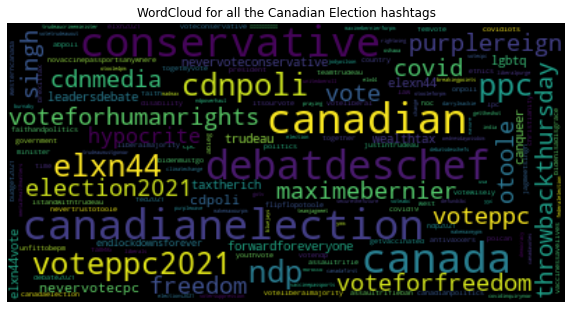

In [11]:
#Hashtags are currently stored in list format, these are exploded and joined as text before using wordcloud feature.
all_hash = CE_21_V1['hashtags'].explode().unique()
all_hash_drop = ' '.join(np.delete(all_hash, 0))

#Applying wordcloud
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(all_hash_drop)

#Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for all the Canadian Election hashtags')
plt.show()

##### 2.1.3 Wordcloud for Canadian Elections handles
- A similar idea can be followed using all the handles that are extracted from the tweets. Some of the handles that are most frequent are: 'thejagmeetsingh', 'erinotootle', 'codyotootle', 'cafreeland', 'maxinebernier' etc. These handles can be referenced with their affliation to a party.

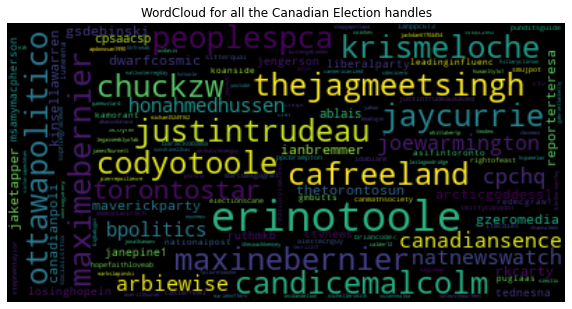

In [12]:
#Handles too are currently stored in the list format, these are exploded and joined for its input to wordcloud feature.
all_hand = CE_21_V1['handles'].explode().unique()

all_hand_drop = ' '.join(np.delete(all_hand, 0))

wordcloud = WordCloud(random_state=21, max_font_size=30).generate(all_hand_drop)

#Plotting Wordcloud for handles
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for all the Canadian Election handles')
plt.show()

#### 2.2 Finding the keywords and the parties affiliations
- The wordclouds above were used as a starting point for identifying keywords related to a specific political party. Those are used to make a list for each. In this study, only a few keywords for tweet project were listed. However, an in-depth investigation can be conducted by looking at politicians' Twitter profiles, party websites, and significant hashtags used during the election campaign, such as #fightingforyou, #forwardforeveryone, and so on, in order to establish a comprehensive and accurate classification.
- After that the function is used to identify a party which was referred in a which tweet. Additionally, the '@' and '#' punctuations which were not eliminated before were eliminated before proceeding to the project of the tweets.

In [13]:
#List of words that identify LPC
LPC = ['liberal', 'liberalparty', 'pm', 'pm' , 'gov', 'government', 'lpc', 'justin', 'trudeau', 'justintrudeau', 'jt', 'cafreeland', 'forwardforeveryone']

#List of words that identify CPC
CPC = [ 'conservativeparty', 'cpc', 'conservative', 'erin', 'otoole', 'codyotoole', 'cpc_hq', 'erinotoole',  'kenney', 'jkenney']

#List of words that identify NDP
NDP = ['jagmeet', 'singh', 'thejagmeetsingh', 'jagmeetsingh', 'ndp', 'newdemocraticparty', 'newdemocratic',  'fightingforyou']

#List of words that identify PPC
PPC = ['maximebernier', 'peoplespca', 'ppc', 'peoplesparty', 'peoplespartyofcanada',  'maxime', 'bernier', 'purple']

In [14]:
#Function to identify the parties being refered in a tweet
def define_party(data):
  #The initial count of each party is 0
  #If a substring relevant to the party belongs to the above list, than the count for that party is increased

  lpc = 0
  for i in LPC:
    for word in str(data).split():
      if i in word:
        lpc+=1
  
  cpc = 0
  for i in CPC:
    for word in str(data).split():
      if i in word:
        cpc+=1
  
  ndp = 0
  for i in NDP:
    for word in str(data).split():
      if i in word:
        ndp+=1
  
  ppc = 0
  for i in PPC:
    for word in str(data).split():
      if i in word:
        ppc+=1
  
  #returns the list of the counts for each party for that particular tweet
  return [lpc, cpc, ndp, ppc]

#Function call
lp = CE_21_V1['text'].apply(lambda x: define_party(re.sub('@|#','',x)))

In [15]:
#Defining separate lists for its use in Venn Diagram
lpc_set = []
cpc_set = []
ndp_set = []
ppc_set = []

#Looping over the length of lp - the list returned from the above function 
for i in range(len(lp)):
  #Storing the count in the specific column in the dataframe
  CE_21_V1.loc[i,'LPC'] = lp[i][0]

  #Appending the value to the list as well for venn diagram
  if lp[i][0]>0:
    lpc_set.append(i)

  #Repeating the steps for all parties
  CE_21_V1.loc[i,'CPC'] = lp[i][1]
  if lp[i][1]>0:
    cpc_set.append(i)

  CE_21_V1.loc[i,'NDP'] = lp[i][2]
  if lp[i][2]>0:
    ndp_set.append(i)

  CE_21_V1.loc[i,'PPC'] = lp[i][3]
  if lp[i][3]>0:
    ppc_set.append(i)

  #if no project is there, adding that tweet to 'Other'
  if lp[i][0]==0 and lp[i][1]==0 and lp[i][2]==0 and lp[i][3]==0:
    CE_21_V1.loc[i,'Other'] = 1
  else:
    CE_21_V1.loc[i,'Other'] = 0

##### 2.2.1 Graphical view of the party tweets and shared tweets as well.

- No maximum count was applied in this distribution plot. All of the count values were taken into account. As a result, the total datapoints are greater than the original length. Because some of the tweets were shared, this is the case. In several tweets, multiple parties are mentioned.

- The 'LPC' party has the largest representation, followed by the 'CPC', the two most popular parties in the election, according to these absolute numbers. Several tweets were labelled as Other, indicating that they belonged to minor political parties or were neutral. The other two parties, 'NDP' and 'PPC,' had a significant share of the dataset as well.

- Now that you've grasped the individual distribution, I have also created an upset plot for visualizing th common tweets between the parties.

- The following conclusions were made from upset plot:
  
  - More than 35% of the tweets were related to alone LPC Party. While CPC party were second highest allocated tweets.
  - Looking at the shared tweets also, we can infer that most of the shared tweets were between LPC and CPC party which was expected.
  - While, it was also interesting to note that 0.5% of tweets were also related to all the parties.
  - From this plot we can infer that most of the people were talking about either LPC or CPC party in their tweets. 

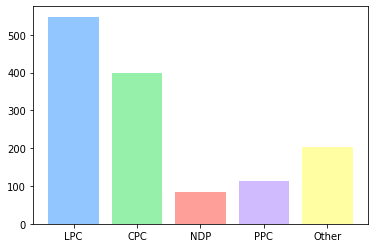

In [16]:
party_list = ['LPC', 'CPC', 'NDP', 'PPC', 'Other']
fig, ax = plt.subplots()
j = 0
for i in party_list:
  ax.bar(party_list[j],CE_21_V1[i].value_counts()[1:].sum())
  j +=1

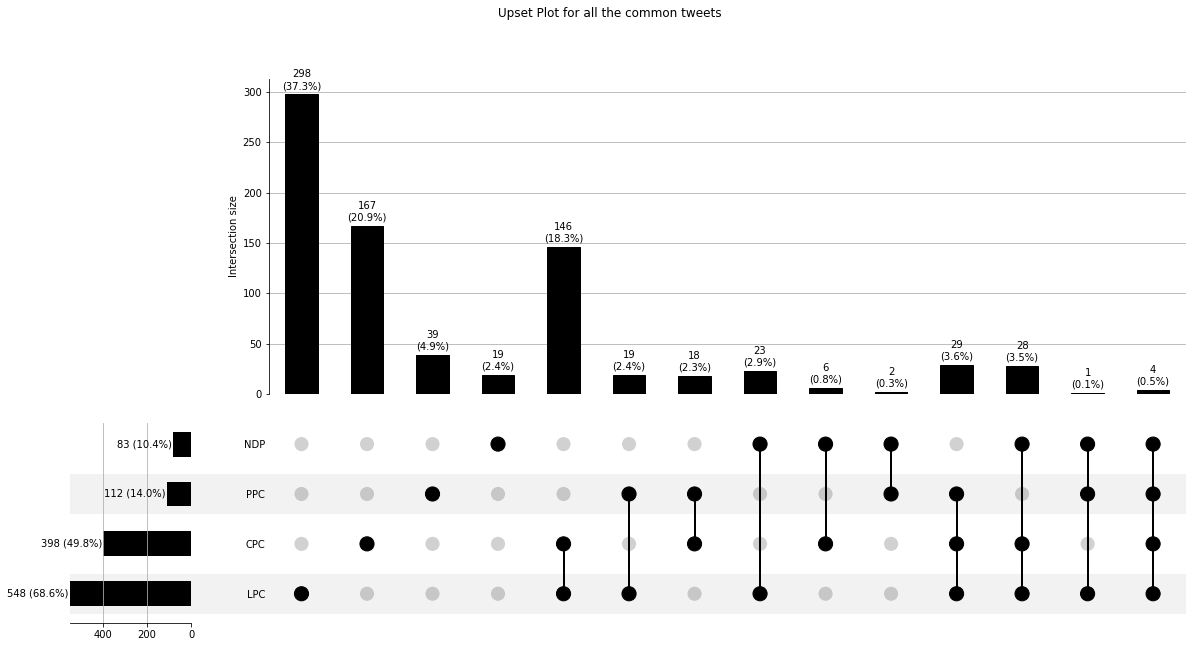

In [17]:
#upset plot for visualizing the common tweets
data = from_contents({"LPC": set(lpc_set), 'CPC':set(cpc_set), 'NDP':set(ndp_set), 'PPC':set(ppc_set)})
fig = plt.figure(figsize=(20, 10))
plot(data, show_counts = True,  fig = fig, show_percentages=True, element_size=None)
plt.suptitle('Upset Plot for all the common tweets')
plt.show()

#### 2.3 Graghical visualization of tweet to one particular party

- The duties that will be introduced later require one party to be assigned to each tweet. The shared tweets dataset is used for this, and the party with the highest count is designated as the 'Party' for that particular tweet.
- The distribution for such a scenario is shown in the cell below. When compared to the counts seen in the previous distribution where shared data was considered, it can be seen that the count for all parties has decreased. This demonstrates that the majority of tweets are shared among the parties.
- The most votes were lost by the 'LPC' and 'CPC' parties. This indicates that they appear in a large number of shared tweets which was also inferred from the above upset plot.

The distribution of tweets with respect to the unique party is: 



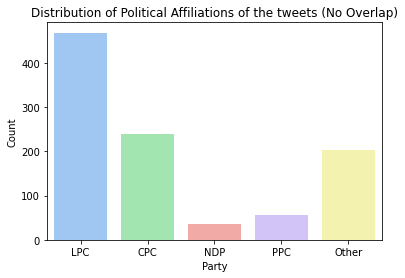

In [18]:
#Store party name with maximum count
CE_21_V1['Max'] = CE_21_V1.loc[:,['LPC','CPC','NDP','PPC','Other']].idxmax(axis=1)

bar_x = CE_21_V1['Max'].value_counts().index
bar_y = CE_21_V1['Max'].value_counts().values
bar_data = pd.DataFrame()
bar_data['Party'] = bar_x
bar_data['Count'] = bar_y

print("The distribution of tweets with respect to the unique party is: \n")
ax = sns.barplot(data=bar_data, x='Party',y='Count', order=['LPC','CPC','NDP','PPC','Other'] );
plt.title('Distribution of Political Affiliations of the tweets (No Overlap)');

#### 2.4 Canadian Election Tweets Visualization

- One of the objectives of this project is to determine the sentiment of a tweet using data from the Canadian election. 'Negative' and 'positive' sentiments are the two types of feelings.
- A wordcloud is used to determine which words are present in both negative and positive tweets. The code below divides the negative and positive tweets into two plots, one for each sentiment.

Discussions:

- Looking at the words in the positive sentiment wordcloud plot, we can see that there is a mix of positive and negative terms.
- The negative wordcloud has a higher percentage of negative words. 'Horrible,' 'weapons,' and'suffering' are some of the things that come to mind while thinking about this plot. Surprisingly, the word 'Trudeau' showed in the negative sentiment plot, implying that the 'LPC' party has a negative sentiment bias.
- A few generic and popular words, such as 'Canadian,' 'Election,' and 'Canada' may have been eliminated as stopwords.

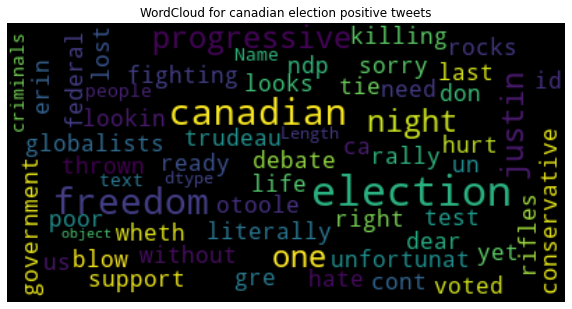

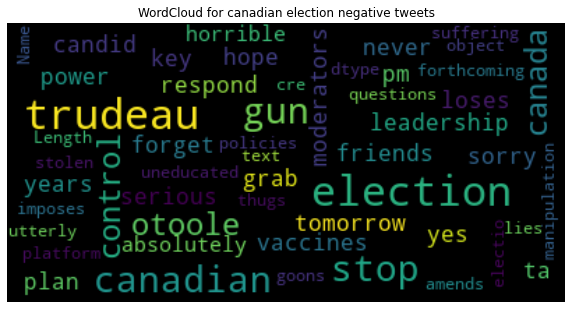

In [19]:
#Processing canadian election tweets
CE_21_V2 = CE_21.copy()
CE_21_V2['text'] = CE_21['text'].apply(lambda x: remove_words(x, rem = True))

#Select tweets with positive sentiment
CE_21_V2_P = CE_21_V2[(CE_21_V2.sentiment=='positive')]
wordcloudp = WordCloud(random_state=21, max_font_size=30).generate(str(CE_21_V2_P['text']))

#Plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloudp, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for canadian election positive tweets')
plt.show()
print("\n")
#Select tweets with negative sentiment
CE_21_V2_N = CE_21_V2[(CE_21_V2.sentiment=='negative')]
wordcloudn = WordCloud(random_state=21, max_font_size=30).generate(str(CE_21_V2_N['text']))
#Plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloudn, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for canadian election negative tweets')
plt.show()

- The below cell of code presents the distribution of negative and positive tweets. It can be seen that positive tweets have a higher representation as compared to negative tweets.
- Among the negative tweets, the reason was also provided. So after that plot the reasons were also plotted, while most were termed as 'Others', a large number of negative tweets were termed negative beacuse of early elections as seen from the distribution plot.

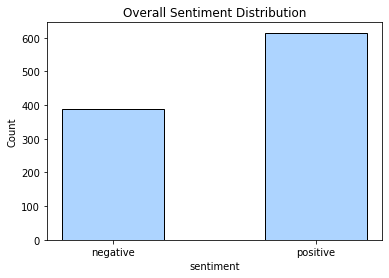

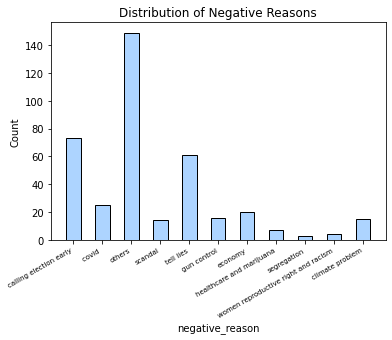

In [20]:
sns.histplot(data=CE_21_V2, x='sentiment',shrink=0.5);
plt.title('Overall Sentiment Distribution')
plt.show()
ax = sns.histplot(data=CE_21_V2, x='negative_reason', shrink=0.5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.title('Distribution of Negative Reasons');
plt.show()

#### 2.5 Generic Sentiment Dataset
- The generic tweets are treated in the same way. As the training set, this dataset will be used. Below is a representation of the positive and negative cloud. In the negative plot, we can plainly observe that higher order negative terms are present.

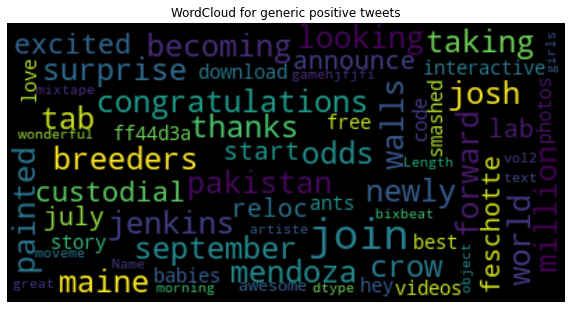

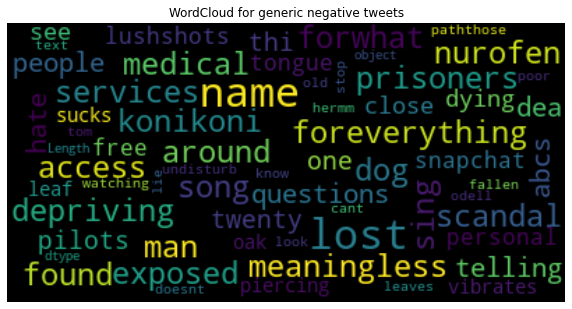

In [21]:
SA_V2 = SA.copy()
SA_V2['text'] = SA_V2['text'].apply(lambda x: remove_words(x, rem = True))

SA_V2_P = SA_V2[(SA_V2.label==1)]
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(str(SA_V2_P['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for generic positive tweets')
plt.show()

SA_V2_N = SA_V2[(SA_V2.label==0)]
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(str(SA_V2_N['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for generic negative tweets')
plt.show()

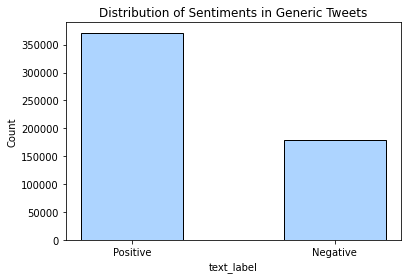

In [22]:
SA_V2['text_label'] = SA_V2['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
ax = sns.histplot(data=SA_V2, x='text_label', shrink=0.5)
plt.title('Distribution of Sentiments in Generic Tweets');
plt.show()

### 3 Sentiment Classification - Model implementation and tuning

#### 3.1 Machine Learninng Models

##### 3.1.1 Pre-setup and vectorizing it.
- Splitting the generic tweets into test and train dataset. 80% of the data is used as training set and the remaining data is considered as a test dataset.
- The original text is than vectorized using TF-IDF Vectorizer with maximum 5000 as number of features.
- The vectorizer is fitted using only the training data. The fitted vectorizer is later used to find the vectorized output for the other sets using the tranform option.

In [23]:
X = SA_V2
y = SA_V2['label']

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)
print('Shape of training set is: ', X_train.shape)
print('Shape of test set is: ', X_test.shape)

Shape of training set is:  (440312, 4)
Shape of test set is:  (110079, 4)


In [24]:
#Defining the TFDIF Vectorizer
vectorizer_2 = TfidfVectorizer(max_features = 5000)
vectorizer_2.fit(X_train['text'].values)

#Tranform the test and validation sets
X_train_tf = vectorizer_2.transform(X_train['text'].values)
X_test_tf = vectorizer_2.transform(X_test['text'].values)

print("Shape after tfdif vectorizations")
print("Train Set X, y: {},{}".format(X_train_tf.shape, y_train.shape))
print("Test Set X, y: {}, {}".format(X_test_tf.shape, y_test.shape))

Shape after tfdif vectorizations
Train Set X, y: (440312, 5000),(440312,)
Test Set X, y: (110079, 5000), (110079,)


##### 3.1.2 Model Implementation

- This section focuses on applying the generated data as input to the 7 different models using various classification algorithms: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest, and XGBoost. These models are run for the features extracted with Tfidf.
- A function is defined which implements the training and predicting the results and calculating train and test accuracy.

In [25]:
#function to implement model training
def execute_model(model, X_tr, y_tr, Xtest, ytest, check=True):
  #Model Fit
  model.fit(X_tr,y_tr)

  #Train Predictions
  y_pred_tr = model.predict(X_tr)

  #check this for the case when XGBClassifier is used.
  if check==False:
    y1 = [round(value) for value in y_pred_tr]
    y_pred_tr = y1
  
  #Calculate Accuracies
  acc_tr = metrics.accuracy_score(y_tr, y_pred_tr)

  #Test Accuracies
  y_preds = model.predict(Xtest)
  acc_test = metrics.accuracy_score(ytest, y_preds)

  #Print Accuracies for comparison
  print("The accuracy score for the Train set is: {}".format(acc_tr))
  print("The accuracy score for the Test set is: {}".format(acc_test))

  pass

##### Model 1: Logistic Regeression Classifier

In [60]:
model1 = LogisticRegression(max_iter=10000)
print("Results when  Logistic Regression model is used:\n")
execute_model(model1, X_train_tf, y_train, X_test_tf, y_test)

Results when  Logistic Regression model is used:

The accuracy score for the Train set is: 0.9683224622540381
The accuracy score for the Test set is: 0.9664877042851043


##### Model 2: KNN Classifier

In [26]:
model2 = KNeighborsClassifier()
print("Results when KNN model is used:\n")
execute_model(model2, X_train_tf, y_train,  X_test_tf, y_test)

Results when KNN model is used:

The accuracy score for the Train set is: 0.8854062573811298
The accuracy score for the Test set is: 0.8265609244270025


##### Model 3: Multinomial Naive Bayes Classifier

In [ ]:
model3 = MultinomialNB()
print("Results when Multinomial NB model is used:\n")
execute_model(model3, X_train_tf, y_train, X_test_tf, y_test)

Results when Multinomial NB model is used:

The accuracy score for the Train set is: 0.93438062101419
The accuracy score for the Test set is: 0.9332570245005859


##### Model 4: Support Vector Classifier

In [44]:
model4 = LinearSVC()
print("Results when Support Vector model is used:\n")
execute_model(model4, X_train_tf, y_train, X_test_tf, y_test)

Results when Support Vector model is used:

The accuracy score for the Train set is: 0.9696397100238013
The accuracy score for the Test set is: 0.9667057295215254


##### Model 5: Decision Tree Classifier

In [ ]:
model5 = DecisionTreeClassifier()
print("Results when Descision Tree model is used:\n")
execute_model(model5, X_train_tf, y_train, X_test_tf, y_test)

Results when Descision Tree model is used:

The accuracy score for the Train set is: 0.9971928995802976
The accuracy score for the Test set is: 0.9440038517791768


##### Model 6: Random Forest Classifier

In [27]:
model6 = RandomForestClassifier()
print("Results when Random Forest model is used:\n")
execute_model(model6, X_train_tf, y_train, X_test_tf, y_test)

Results when Random Forest model is used:

The accuracy score for the Train set is: 0.99718381511292
The accuracy score for the Test set is: 0.9582935891496107


##### Model 7: XG-Boost Classifier

In [ ]:
model7 = XGBClassifier()
print("Results when  XGBoost model is used:\n")
execute_model(model7, X_train_tf, y_train, X_test_tf, y_test, False)

Results when  XGBoost model is used:

The accuracy score for the Train set is: 0.8493113973727721
The accuracy score for the Test set is: 0.8511251010637815


##### 3.1.3 Conclusion
- The SVM model with input features collected using the CountVectorizer fared best on the test set.
- Another model which had similar performance was the Logistic Regression model. The model performed extremely well on the training set achieving an a good accuracy close enough to SVM model.
- Although other models might perform better upon hyperparameter tuning. But, as this is not the focus of this task, that comparison was not performed.

In [ ]:
# this cell should be ignored and is just included so that TA can see the table of content in a proper arranged way

#### 3.2 Neural Network

##### 3.2.1 Part 1: Model building from scratch
- In the below code, I have build the architechture and trained that model from scratch using pytorch.
- First, I have splitted the dataframes into train, test and valid and then vectorized using bag of words methods having **max features as 5000**.
- Then converted that csr_matrix to spare tensor to feed in the model.
- I have defined an architechture with 1 linear layer (I have tried LSTM as well but 1 epoch of that model was taking 1 hr to train so eventually have to drop that out due to computational issue.)
- I have trained the model and calculated the train loss, validation loss and validation accuracy. 
- From the results, we can see the model is learning and we can achieve 91% validation accuracy just by training it for 5 epochs. (have to limit to 5 epoch as this model was out of the computational power of my laptop and colab and still it took 2.5 hrs to train).
- Due to more time consumption I have further decided to use the SKlearn Library MLP Classifier and tuned the hyperparameters on it. But, for reference I have also kept the model built from scratch (hope this does not deduct my marks as I tried for 2 days with GPUs and TPUs of Colab but after 3 epoch the runtime was crashing for me).
- The MLP classifier also gave good accuracy which could be also achieved if I would have trained the model for more epochs.
- The part 2 of this part discuss the MLP classifier model in detail.


In [32]:
#splitting the dataset
X_train_dl, X_temp_dl, y_train_dl, y_temp_dl = train_test_split(X, y, test_size=0.4, random_state=100)
X_val_dl, X_test_dl, y_val_dl, y_test_dl = train_test_split(X_temp_dl, y_temp_dl, test_size=0.5, random_state=100)

print('Shape of training set is: ', X_train_dl.shape)
print('Shape of validation set is: ', X_val_dl.shape)
print('Shape of test set is: ', X_test_dl.shape)

Shape of training set is:  (330234, 4)
Shape of validation set is:  (110078, 4)
Shape of test set is:  (110079, 4)


In [33]:
#Defining the Vectorizer
vectorizer_1 = CountVectorizer(max_features = 5000)
vectorizer_1.fit(X_train['text'].values)

#Transforming Data
X_train_bag = vectorizer_1.transform(X_train_dl['text'].values)
X_val_bag = vectorizer_1.transform(X_val_dl['text'].values)
X_test_bag = vectorizer_1.transform(X_test_dl['text'].values)

y_train_bag = torch.tensor(y_train_dl.values)
y_val_bag = torch.tensor(y_val_dl.values)
y_test_bag = torch.tensor(y_test_dl.values)

print("Shape after count vectorizations")
print("Train Set X, y: {},{}".format(X_train_bag.shape, y_train_bag.shape))
print("Test Set X, y: {},{}".format(X_val_bag.shape, y_val_bag.shape))
print("Test Set X, y: {}, {}".format(X_test_bag.shape, y_test_bag.shape))

Shape after count vectorizations
Train Set X, y: (330234, 5000),torch.Size([330234])
Test Set X, y: (110078, 5000),torch.Size([110078])
Test Set X, y: (110079, 5000), torch.Size([110079])


In [34]:
#converting the csr matrix to spare tensors
X_train_bag_dl = X_train_bag.tocoo()
X_train_bag_tensor = torch.sparse.LongTensor(torch.LongTensor([X_train_bag_dl.row.tolist(), X_train_bag_dl.col.tolist()]),
                              torch.LongTensor(X_train_bag_dl.data.astype(np.float64)))

X_val_bag_dl = X_val_bag.tocoo()
X_val_bag_tensor = torch.sparse.LongTensor(torch.LongTensor([X_val_bag_dl.row.tolist(), X_val_bag_dl.col.tolist()]),
                              torch.LongTensor(X_val_bag_dl.data.astype(np.float64)))

X_test_bag_dl = X_test_bag.tocoo()
X_test_bag_tensor = torch.sparse.LongTensor(torch.LongTensor([X_test_bag_dl.row.tolist(), X_test_bag_dl.col.tolist()]),
                              torch.LongTensor(X_test_bag_dl.data.astype(np.float64)))

In [35]:
#defining function to get model for saving weights
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [36]:
#create Tensor Dataset
train_data=TensorDataset(X_train_bag_tensor,y_train_bag)
valid_data=TensorDataset(X_val_bag_tensor,y_val_bag)
test_data=TensorDataset(X_test_bag_tensor, y_test_bag)

#dataloader
batch_size=512
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
#defining the architecture
class Network(torch.nn.Module):
  def __init__(self,vocab_size,num_classes): 
    super().__init__()
    self.name = "Sentiment"
    #First fully connected layer
    self.fc1 = nn.Linear(vocab_size,num_classes)
    #Final output of sigmoid function      
    self.output = nn.Sigmoid()
  def forward(self,x):
    x = x.to_dense().float()
    fc1 = self.fc1(x)
    output = self.output(fc1)
    return output[:, -1]

In [ ]:
# Instantiate the model
vocab_size = 5000
hidden_units = 1024
num_classes = 2
model = Network(vocab_size,num_classes)
print(model)

Network(
  (fc1): Linear(in_features=5000, out_features=2, bias=True)
  (output): Sigmoid()
)


In [ ]:
#training the model

NUM_EPOCHS = 5
VOCAB_SIZE = 5000
HIDDEN_UNITS = 1024
OUT_CLASSES = 2
LEARNING_RATE = 0.1

#Initialize model
model = Network(VOCAB_SIZE,OUT_CLASSES)

#checking if cuda is available   
if torch.cuda.is_available():
  print("Training on GPU")
  model.cuda()
print(model)

#Initialize optimizer
optimizer =torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Initialize loss function
criterion = nn.BCELoss()

#training the model till epochs defined
for i in tqdm(range(NUM_EPOCHS)):

  #training mode
  model.train()
  for x_batch,y_batch in train_loader:
    y_pred = model(x_batch)
    loss = criterion(y_pred,y_batch.float())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #validating the model using the weights trained
  model.eval()  
  val_losses = []
  correct = 0
  total = 0
  for inputs, labels in valid_loader:
    output = model(inputs)
    val_loss = criterion(output.squeeze(), labels.float())
    val_losses.append(val_loss.item())
    pred = torch.round(output.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct_label = np.squeeze(correct_tensor.numpy())
    correct += np.sum(correct_label)
    total += labels.shape[0]
  acc = correct/total

  #printing the loss and accuracy
  print('{} epoch. Training loss: {} || Validation loss: {} || Validation Acc: {}'.format(i,loss.item(),np.mean(val_losses),acc))

  #saving the weights for further use
  model_path = get_model_name(model.name, batch_size = batch_size, learning_rate = LEARNING_RATE, epoch = i)
  torch.save(model.state_dict(), model_path)

Network(
  (fc1): Linear(in_features=5000, out_features=2, bias=True)
  (output): Sigmoid()
)


 20%|██        | 1/5 [27:37<1:50:29, 1657.29s/it]

0 epoch. Training loss: 0.5023908019065857 || Validation loss: 0.47791832990424576 || Validation Acc: 0.7204164319845927


 40%|████      | 2/5 [57:45<1:27:18, 1746.18s/it]

1 epoch. Training loss: 0.4091530442237854 || Validation loss: 0.41660381805065066 || Validation Acc: 0.8126964516070423


 60%|██████    | 3/5 [1:27:46<59:02, 1771.07s/it]

2 epoch. Training loss: 0.3873409330844879 || Validation loss: 0.37894786429959676 || Validation Acc: 0.8756972328712368


 80%|████████  | 4/5 [1:55:14<28:42, 1722.46s/it]

3 epoch. Training loss: 0.34086331725120544 || Validation loss: 0.3523618089598279 || Validation Acc: 0.8992078344446665


100%|██████████| 5/5 [2:22:11<00:00, 1706.33s/it]

4 epoch. Training loss: 0.34410974383354187 || Validation loss: 0.3321111670760221 || Validation Acc: 0.9184305674158324


In [ ]:
#loading the last saved epoch weights for test dataset
VOCAB_SIZE = 5000
OUT_CLASSES = 2
LEARNING_RATE = 0.1
epoch = 4
model = Network(VOCAB_SIZE,OUT_CLASSES)
model_path = get_model_name(model.name, batch_size=batch_size, learning_rate=LEARNING_RATE, epoch=epoch)
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
#testing on the test dataset using the loaded weights
correct_test = 0
total_test = 0
test_losses = []

for inputs, labels in test_loader:
  output = model(inputs)
  test_loss = criterion(output.squeeze(), labels.float())
  test_losses.append(test_loss.item())
  pred = torch.round(output.squeeze())
  correct_tensor = pred.eq(labels.float().view_as(pred))
  correct_label = np.squeeze(correct_tensor.numpy())
  correct_test += np.sum(correct_label)
  total_test += labels.shape[0]
acc_test = correct_test/total_test

print("Test loss: {} || Test Accuracy: {}".format(np.mean(test_losses), acc_test))

Test loss: 0.3334276454393254 || Test Accuracy: 0.9167143596871338


##### 3.2.2 Part 2: Using MLP Classifier from Library
- As the model built from scratch was taking too long time (2.5 hrs). I was not able to perfrom the hyperparameter tuning on that and additionally the accuracy of the model was also as I have only 1 linear layer in the architechture and using LSTM is not worth the time as it would take magnanimous amount of the computational power and time. Thus, I have used the MLP Classifier library from Scikit Learn to model and tune MLP Classifier.
- From the below cell of code, I have first trained the model once using certain hyperparameters and I got 96.1% as the validation accuracy.

In [ ]:
clf1 = MLPClassifier(hidden_layer_sizes = 200, batch_size=512, learning_rate_init = 0.01, shuffle = True, verbose = False, random_state=1, max_iter=200).fit(X_train_bag, y_train_dl)
y_train_pred = clf1.predict(X_train_bag)
y_val_pred = clf1.predict(X_val_bag)
train_acc_1 = metrics.accuracy_score(y_train_dl, y_train_pred)
val_acc_1 = metrics.accuracy_score(y_val_dl, y_val_pred)
print('The training accuracy without hyperparameter tuning is: ', train_acc_1)
print('The validation accuracy without hyperparameter tuning is: ', val_acc_1)

The training accuracy without hyperparameter tuning is:  0.9965933247333709
The validation accuracy without hyperparameter tuning is:  0.9610094660150076


##### 3.2.3 Hyperparameter Tuning
- The below cell represents the hyperparameter tuning using two parameters
1. Learning Rate = [0.1, 0.001]
2. Hidden Units = [50, 100]
- In total 4 models will be there and final model will be selected based on the best accuracy obtained and tested on the test dataset.

In [ ]:
learning_rate_init = [0.1, 0.001]
hidden_units = [50,100]
results_df = pd.DataFrame(columns = ['Model_no', 'Learning_Rate', 'Hidden_Units','Training_acc', 'Validation_acc'])
i = 1
for lr in learning_rate_init:
  for hs in hidden_units:
    clf = MLPClassifier(hidden_layer_sizes = hs, batch_size=512, learning_rate_init = lr, shuffle = True, verbose = True, 
                        random_state=1, max_iter=100).fit(X_train_bag, y_train_dl)
    y_train_pred = clf.predict(X_train_bag)
    y_val_pred = clf.predict(X_val_bag)
    train_acc = metrics.accuracy_score(y_train_dl, y_train_pred)
    val_acc = metrics.accuracy_score(y_val_dl, y_val_pred)
    results_df = results_df.append({'Model_no': i, 'Learning_Rate': lr, 'Hidden_Units': hs,'Training_acc': train_acc, 'Validation_acc': val_acc}, ignore_index = True)
    i = i + 1

In [39]:
results_df

,Model_no,Learning_Rate,Hidden_Units,Training_acc,Validation_acc
0,1.0,0.100,50.0,0.977619,0.962908
1,2.0,0.100,100.0,0.974951,0.959610
2,3.0,0.001,50.0,0.971550,0.965661
3,4.0,0.001,100.0,0.972871,0.965897


##### 3.2.4 Testing the dataset
- From the above dataframe, we can see the model with learning rate 0.001 and hidden_units 100 performed best with 96.59% accuracy.
- The below cell of code represents the final model selected based on hyperparameter tuning on test dataset.

In [41]:
clf2 = MLPClassifier(hidden_layer_sizes = 100, batch_size=512, learning_rate_init = 0.001, shuffle = True, verbose = False, random_state=1, max_iter=100).fit(X_train_bag, y_train_dl)
y_train_pred = clf2.predict(X_train_bag)
y_val_pred = clf2.predict(X_val_bag)
y_test_pred = clf2.predict(X_test_bag)
train_acc_2 = metrics.accuracy_score(y_train_dl, y_train_pred)
val_acc_2 = metrics.accuracy_score(y_val_dl, y_val_pred)
test_acc_2 = metrics.accuracy_score(y_test_dl, y_test_pred)
print('The training accuracy with hyperparameter tuning is: ', train_acc_2)
print('The validation accuracy with hyperparameter tuning is: ', val_acc_2)
print('The test accuracy with hyperparameter tuning is: ', test_acc_2)

The training accuracy with hyperparameter tuning is:  0.9972019840476752
The validation accuracy with hyperparameter tuning is:  0.9651610676066062
The test accuracy with hyperparameter tuning is:  0.9641893549178318


#### 3.3 Evaluation
- The resulting model is then tested on the Canadian election dataset to see how well it performs.
- For this dataset, the accuracy was 0.718. When compared to the performance of the generic dataset, we can plainly observe that the performance degrades. The datasets have a lot of differences in terms of characteristics.
- The feature sets of these datasets could be one explanation for this observation.
1. Some of the important words that can be important for tweet classification in the Canadian election dataset, such as 'trudeau,' 'ootole,' and other party relevant keywords that can drive sentiment, have an extremely low probability of occurence in the generic tweet dataset, as seen in the negative clouds observed during the data exploration task.
2. In the positive wordclouds, a similar tendency may be seen.
As a result, there is a decrease in performance.
3. Additionally, after plotting the feature importance graph we can clearly see that the negative words like hate, sad, upset, racist etc are used by the model to classify the tweets but from the data exploration task we can clearly see that these words were not present in the negative words cloud. Thus, we can say that this model will not perform well on Canadian Election Dataset.

In [46]:
#training the model again just to be sure.
model_final = LinearSVC(max_iter=10000)
model_final.fit(X_train_tf,y_train)
y_preds = model_final.predict(X_test_tf)
accs = metrics.accuracy_score(y_test, y_preds)
print("The accuracy score for the Test set is: {}".format(accs))

The accuracy score for the Test set is: 0.9667057295215254


In [114]:
CE_21_V1['label'] = CE_21_V1['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
X_CE_21 = CE_21_V1
y_CE_21 = CE_21_V1['label']
X_CE_bag = vectorizer_2.transform(X_CE_21['text'].values)
y_CE_pred = model_final.predict(X_CE_bag)
CE_acc = metrics.accuracy_score(y_CE_21, y_CE_pred)
print("The accuracy score for the Test set on the Canadian Election dataset is: {}".format(CE_acc))

The accuracy score for the Test set on the Canadian Election dataset is: 0.718562874251497


In [211]:
def visualize(y_can, y_preds, n=2):

  f1_scr = metrics.f1_score(y_can, y_preds, average=None)
  print("\nThe F1 score for each class is: {}".format(f1_scr))
  cm = confusion_matrix(y_can, y_preds)

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
  sns.heatmap(cm, annot=True, ax = ax1,fmt='g', cmap="YlGnBu")
  ax1.set_xlabel('Predicted labels');
  ax1.set_ylabel('True labels');
  ax1.set_title('Confusion Matrix Plot for Dataset')
  
  CE_true = np.sum(cm, axis=1)
  CE_pred = np.sum(cm, axis=0)

  ind = np.arange(n)
  rects1 = ax2.bar(ind, CE_true, width=0.1, label='True Class')
  rects2 = ax2.bar(ind+0.1, CE_pred, width=0.1, label='Predicted Class')
  ax2.set_xticks(ind)
  ax2.legend()
  ax2.set_title("Class Distribution")
  ax2.set_xlabel('Classes')
  ax2.set_ylabel('Counts')
  plt.show()

def f_importances(X_data, Y_data):

  f_imp_vector = TfidfVectorizer(max_features = 5000).fit(X_data['text'].values)
  X_train_matrix = f_imp_vector.transform(X_data['text'].values)
  names = vectorizer_2.get_feature_names_out()
  model_final = LinearSVC(max_iter=10000).fit(X_train_matrix, Y_data)
  imp = model_final.coef_
  imp_neg,names_neg = zip(*sorted(zip(imp[0],names)))
  imp_pos,names_pos = zip(*sorted(zip(imp[0],names), reverse= True))
  imp = imp_neg[0:25] + imp_pos[0:25]
  names = names_neg[0:25] + names_pos[0:25]
  fig1,ax1= plt.subplots(figsize=(8,8))
  ax1.barh(names_neg[0:25], imp_neg[0:25], align='center', color = '#FF7F7F')
  ax1.set_xlabel('Imporatance score')
  ax1.set_ylabel('Important Negative Words')
  ax2 = ax1.twinx()
  ax2.barh(names_pos[0:25], imp_pos[0:25], align='center', color = '#A1F7A7')
  ax2.set_ylabel('Important Positive Words')
  plt.title('Top 25 negative and positive features (total 50) used to classify')
  plt.show()

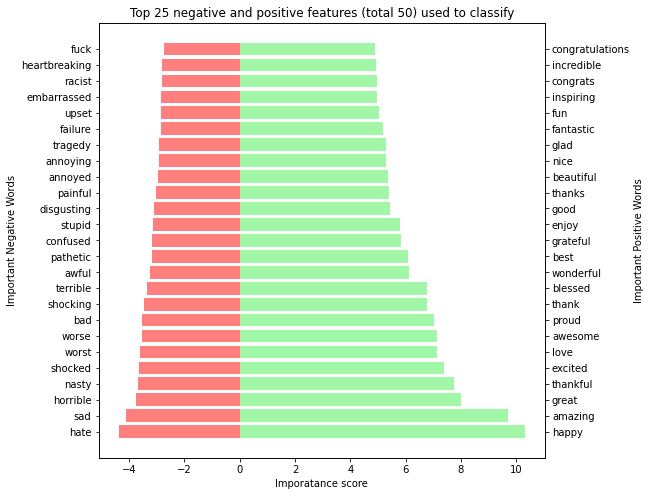

In [212]:
f_importances(X_train, y_train)

#### 3.4 Two Evaluation Metrics
- The goal of this project is to categorise tweets depending on their sentiment. It could be both beneficial and negative. Given that both of these classes are equally important and that a class imbalance exists (though not to a severe degree, i.e., 67 percent of the datapoints belong to the positive class, which is the majority class), the previously discussed evaluation metric 'accuracy score' appears to be a viable option. During the metric calculation, it focuses more on the true positive and true negative.

- The other two options which can be explored for the performance evalution are:

1. **F1 Score:** F1 score can be used in circumstances where there is a class imbalance. It addresses the issue of incorrect classifications and provides a more accurate evaluation metric than the accuracy score. 

2. **ROC AUC:** When the accuracy score is set to 0.5, the class labels are generated. However, several criteria exist for which the model's performance is best. The importance of analysing these thresholds cannot be overstated. The ROC AUC graph is used to visualise the results. This can also be used to see how the plot changes when you use a different model. For example, for each model, a visual graph can be created, and the performance can be compared.

#### 3.5 Plots for each party

##### LPC Party
- When comparing the results with the whole dataset, it can be seen that the accuracy has decreased. 
- The positive and negative labels are evenly distributed in the dataset, according to the distribution. The negative labels had a higher frequency in the forecasts. The outcome is comparable to that of the entire dataset.
- The feature importance plot shows the public opinion based on the senitiment values. The negative and positive words can be useful for the party to make their agenda and propoganda for next year election.

The accuracy score for the LPC Party is: 0.7243589743589743

The F1 score for each class is: [0.75797373 0.67990074]


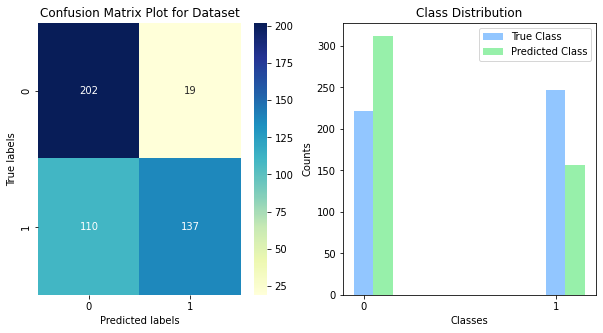

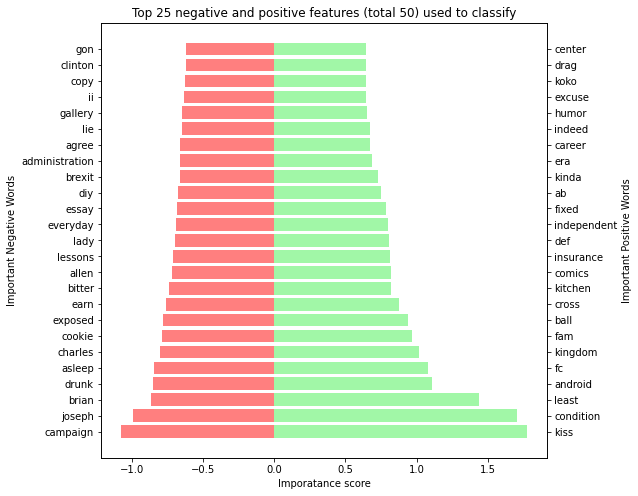

In [213]:
#LPC
CE_LPC = CE_21_V1[CE_21_V1['Max']=='LPC']
X_CE_LPC = CE_LPC
y_CE_LPC = CE_LPC['label']
X_CE_bag_LPC = vectorizer_2.transform(X_CE_LPC['text'].values)

y_pred_LPC = model_final.predict(X_CE_bag_LPC)

acc_CE_LPC = metrics.accuracy_score(y_CE_LPC, y_pred_LPC)
  
print("The accuracy score for the LPC Party is: {}".format(acc_CE_LPC))
visualize(y_CE_LPC, y_pred_LPC)
f_importances(X_CE_LPC, y_CE_LPC)

##### CPC Party
- The CPC party has the second largest share in the dataset. In the genuine dataset, the CPC party had a higher proportion of positive labels than the LPC party, in contrary to the LPC's emotion.
- A similar pattern can be seen in the projections. Negative labels were commonly predicted. This could indicate that some of the positive-labeled tweets contained negative terms.
- The observed accuracy is also higher than that of the entire dataset (0.718).
- The feature importance plot shows the public opinion based on the senitiment values. The negative and positive words can be useful for the party to make their agenda and propoganda for next year election.

The accuracy score for the CPC Party is: 0.7489539748953975

The F1 score for each class is: [0.70588235 0.7810219 ]


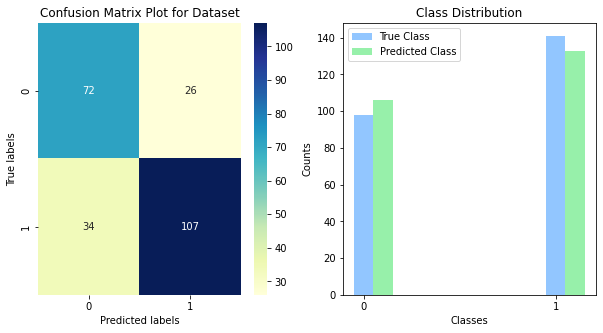

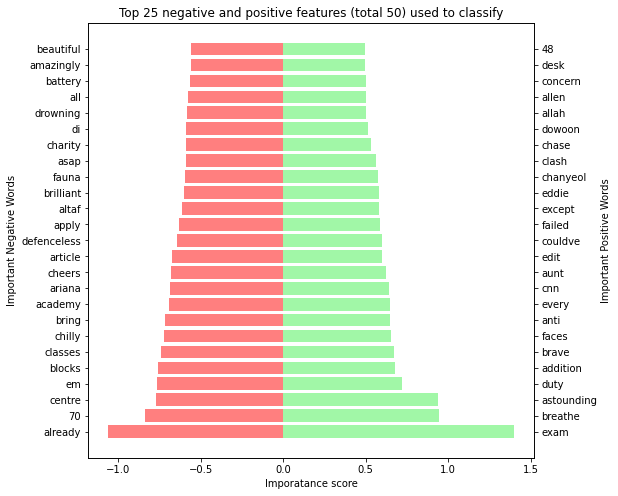

In [214]:
#CPC
CE_CPC = CE_21_V1[CE_21_V1['Max']=='CPC']
X_CE_CPC = CE_CPC
y_CE_CPC = CE_CPC['label']
X_CE_bag_CPC = vectorizer_1.transform(X_CE_CPC['text'].values)
y_pred_CPC = model_final.predict(X_CE_bag_CPC)
acc_CE_CPC = metrics.accuracy_score(y_CE_CPC, y_pred_CPC)
print("The accuracy score for the CPC Party is: {}".format(acc_CE_CPC))
visualize(y_CE_CPC, y_pred_CPC)
f_importances(X_CE_CPC, y_CE_CPC)

##### NDP Party
- The NDP had a lower share of the vote in the sample than the other two parties. However, when compared to the rest of the distribution, the number of good tweets outnumbers the number of negative tweets. A similar pattern can be noticed in terms of forecasting. The anticipated negative tweets are higher than the original bad tweets.
- The feature importance plot shows the public opinion based on the senitiment values. The negative and positive words can be useful for the party to make their agenda and propoganda for next year election.

The accuracy score for the NDP Party is: 0.9142857142857143

The F1 score for each class is: [0.72727273 0.94915254]


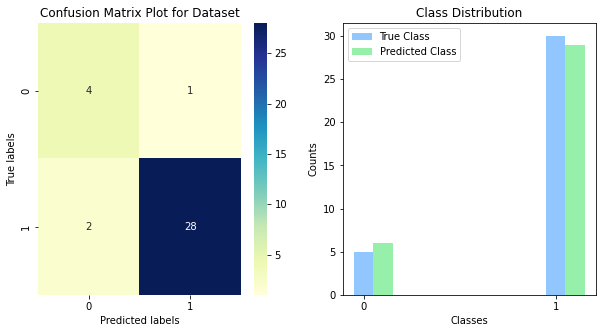

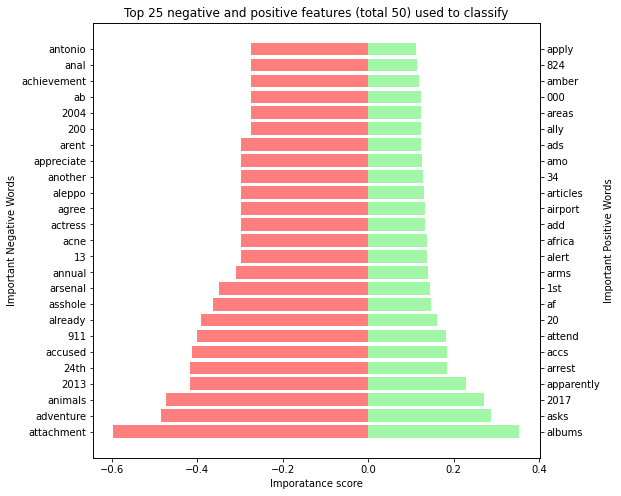

In [215]:
#NDP
CE_NDP = CE_21_V1[CE_21_V1['Max']=='NDP']
X_CE_NDP = CE_NDP
y_CE_NDP = CE_NDP['label']
X_can_bag_NDP = vectorizer_1.transform(X_CE_NDP['text'].values)
y_pred_NDP = model_final.predict(X_can_bag_NDP)
acc_CE_NDP = metrics.accuracy_score(y_CE_NDP, y_pred_NDP)
print("The accuracy score for the NDP Party is: {}".format(acc_CE_NDP))
visualize(y_CE_NDP, y_pred_NDP)
f_importances(X_CE_NDP, y_CE_NDP)

##### PPC Party
- The PPC Party has a higher share of the positive tweet as well in the original dataset. However, the accuracy is the lowest.
- The feature importance plot shows the public opinion based on the senitiment values. The negative and positive words can be useful for the party to make their agenda and propoganda for next year election.

The accuracy score for the PPC Party is: 0.7017543859649122

The F1 score for each class is: [0.48484848 0.79012346]


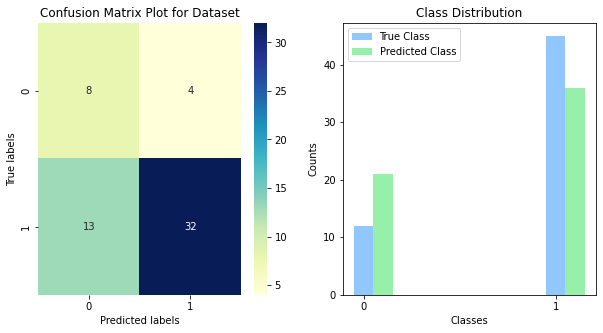

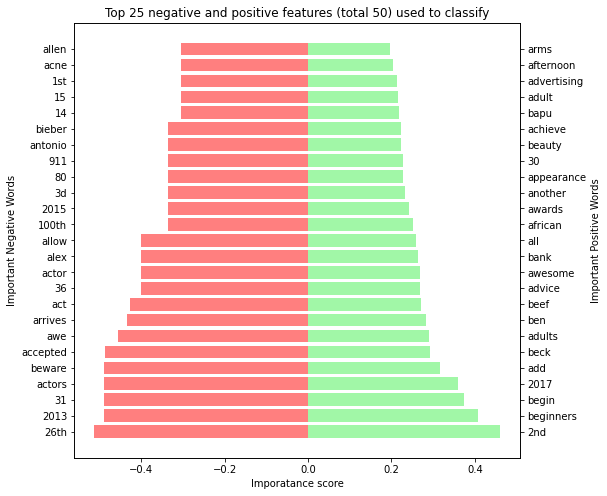

In [216]:
#PPC
CE_PPC = CE_21_V1[CE_21_V1['Max']=='PPC']
X_CE_PPC = CE_PPC
y_CE_PPC = CE_PPC['label']
X_CE_bag_PPC = vectorizer_1.transform(X_CE_PPC['text'].values)
y_pred_PPC = model_final.predict(X_CE_bag_PPC)
acc_CE_PPC = metrics.accuracy_score(y_CE_PPC, y_pred_PPC)
print("The accuracy score for the PPC Party is: {}".format(acc_CE_PPC))
visualize(y_CE_PPC, y_pred_PPC)
f_importances(X_CE_PPC, y_CE_PPC)

#### Conclusion

- When compared to the other two parties, the prediction accuracy of 'LPC' and 'PPC' was lower.
- Although the accuracy was not perfect in all cases, the NLP techniques can undoubtedly be utilized by political parties in election campaigns to take accurate measures, promotions, and changes in order to improve their image. In order to acquire accurate model performance, the dataset used to train the model will be critical. The tweets in the Canadian election sample had some negative terms that were categorised as positive sentiment. This may be accurate, but it will result in differences in the results because the dataset in the generic tweets contained a very diverse set of positive words.
- The negative and favourable tweets for the LPC party are distributed similarly. This indicates that the sentiment is balanced, with a minor positive inclination. The CPC party, on the other hand, has a larger ratio of good to negative tweets. The CPC party's tweets had a larger percentage of positive tweets. The majority of the tweets mentioning NDP and LPC were good. This suggests that while their public image was positive, they were not as popular as the other two parties.

**Idea to imporve accuracy**
- The initial approach for improving the model's accuracy is to exclude words like "canadian," "canada," and "election" that don't contribute any extra information about the subject. This will narrow down the total characteristics even more, allowing you to concentrate on the other relevant key phrases. Additionally, some more stopwords for both datasets can be added to see how the accuracies vary.

### 4 Negative Reason Classification

The negative labelled data in the Canadian election dataset is the topic of this section. The dataset is then divided into two parts: a training set of 70% and a testing set of 30%. Some of the rarely occuring reasons such as 'healthcare and marijuana', 'segregation', and 'women reproductive right and racism' were combined with 'Others'. In the hyperparameters tuning, a 'cv' of 10 was used. Hence, the reasons which had a count of less than 10 were combined with others.

In [228]:
#remove the dataframe just in case if it is re-ran
try:
  del CE_neg
except:
  pass

#Selecting the negative sentiment only
CE_neg = CE_21_V1[CE_21_V1['sentiment']=='negative']

#Replacing some points with lower frequency into others
CE_neg.loc[CE_neg['negative_reason']=='healthcare and marijuana'] = 'others'
CE_neg.loc[CE_neg['negative_reason']=='segregation'] = 'others'
CE_neg.loc[CE_neg['negative_reason']=='women reproductive right and racism'] = 'others'

#Splitting X and y for model input
X_CE_neg = CE_neg
y_CE_neg = CE_neg['negative_reason']
X_CE_neg_train, X_CE_neg_test, y_CE_neg_train, y_CE_neg_test = train_test_split(X_CE_neg, y_CE_neg, test_size=0.30, random_state=100)

#Use countVectorizer()
vectorizer_3 = CountVectorizer()
vectorizer_3.fit(X_CE_neg_train['text'].values)

#Transform the test and the train data using the fitted vectorizer
X_CE_neg_tr_bag = vectorizer_3.transform(X_CE_neg_train['text'].values)
X_CE_neg_ts_bag = vectorizer_3.transform(X_CE_neg_test['text'].values)

print("Shape after count vectorizations")
print("Train Set X, y: {},{}".format(X_CE_neg_tr_bag.shape, y_CE_neg_train.shape))
print("Test Set X, y: {}, {}\n".format(X_CE_neg_ts_bag.shape, y_CE_neg_test.shape))

Shape after count vectorizations
Train Set X, y: (270, 1966),(270,)
Test Set X, y: (117, 1966), (117,)



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [229]:
#counting the number of negative reasons
dummies_i = pd.get_dummies(CE_neg['negative_reason'], prefix='y')
print(np.sum(dummies_i, axis=0))

y_calling election early     73
y_climate problem            15
y_covid                      25
y_economy                    20
y_gun control                16
y_others                    163
y_scandal                    14
y_tell lies                  61
dtype: int64


#### 4.1 Negative reason model implementation


##### 4.1.1 Hyperparameter Tuning
- The below cell of code implements a function for grid search cv. The function also plots a graph for the values of hyperparameter. 
- The first one indicates the mean accuracy score for each hyperparameter value.
- The parameter for which the total error is less was selected as the best parameter.

In [242]:
def execute_model_neg(model, X, y, params, scoring):
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
  clf = GridSearchCV(model, param_grid, scoring=scoring, cv=kfold, return_train_score=True)
  clf.fit(X, y)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_{}'.format(list(params.keys())[0])])
  print("The parameter is: {}".format(['param_{}'.format(list(params.keys())[0])]))
  train_score_mean = results['mean_train_score']
  train_score_std = results['std_train_score']
  cv_score_mean = results['mean_test_score']
  cv_score_std = results['std_test_score']
  K = results['param_{}'.format(list(params.keys())[0])]
  plt.plot(K, train_score_mean, label='Train Score')
  plt.plot(K, cv_score_mean, label='CV Score')
  plt.xscale('log')
  plt.legend()
  plt.xlabel("K: hyperparameter")
  plt.ylabel("Score")
  plt.title("Hyper parameter Vs Accuracy Score plot")
  plt.grid()
  plt.show()
  print("\nThe best parameter value is: {}".format(clf.best_params_))
  print("\nThe best score is: {}".format(clf.best_score_))
  return clf.best_score_, clf.best_params_, clf.best_estimator_

##### 4.1.2 Selected Model: LinearSVC
- For this task, Linear SVC was preferred just to have a comparison with the results from previous section as in previous section this model performed best. Although the performance of the model on the test set is extremely poor in comparison to that of the training set.

Results when Count Vectorizer input is selected:

The parameter is: ['param_C']


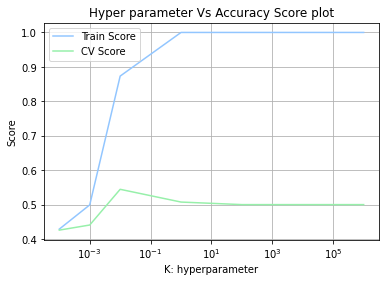


The best parameter value is: {'C': 0.01}

The best score is: 0.5444444444444444


In [244]:
model_neg = LinearSVC(max_iter=10000)
C = [0.0001, 0.001, 0.01, 1, 100, 1000, 10000, 100000, 1000000]
param_grid = dict(C=C)
print("Results when Count Vectorizer input is selected:\n")
best_score, best_param, best_est = execute_model_neg(model_neg, X_CE_neg_tr_bag, y_CE_neg_train, param_grid, 'accuracy')

##### Plotting for train and test dataset
- The final model's hyperparameters are then set, and the model's performance is evaluated throughout the entire training set. As can be observed, the model performs admirably. This indicates that overfitting is present in this scenario. The dataset is quite tiny, which makes it even more difficult to improve the test results with the same dataset.
- We can observe from the hyperparameter tweaking section that the cross validation set's accuracy was relatively poor. However, when the entire training dataset is taken into account, the accuracy is 100 percent. This emphasises the issue of low datapoints.
- The trained model is applied on the test dataset after understanding the training performance. It is clear that the model's performance has deteriorated significantly. The F1 score is also presented to show how each class scored.

The accuracy score for the Train negative tweets: 0.8703703703703703

The F1 score for each class is: [0.97247706 0.53333333 0.69565217 0.9        0.95652174 0.87452471
 0.66666667 0.83333333]


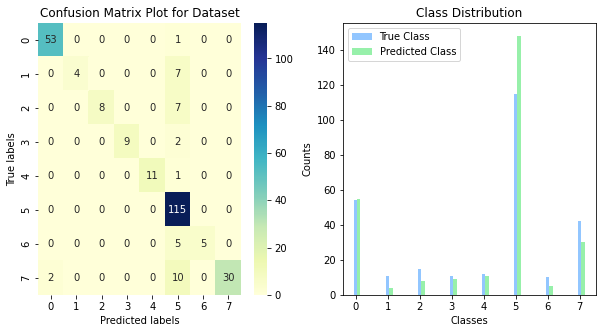

In [249]:
model_neg = LinearSVC(max_iter=10000, C=0.01)
model_neg.fit(X_CE_neg_tr_bag,y_CE_neg_train)
y_pred_neg_tr = model_neg.predict(X_CE_neg_tr_bag)
accs_neg_tr = metrics.accuracy_score(y_CE_neg_train, y_pred_neg_tr)
print("The accuracy score for the Train negative tweets: {}".format(accs_neg_tr))
visualize(y_CE_neg_train, y_pred_neg_tr, n=8)

The accuracy score for the Train negative tweets: 0.5299145299145299

The F1 score for each class is: [0.66666667 0.4        0.         0.         0.         0.67153285
 0.         0.        ]


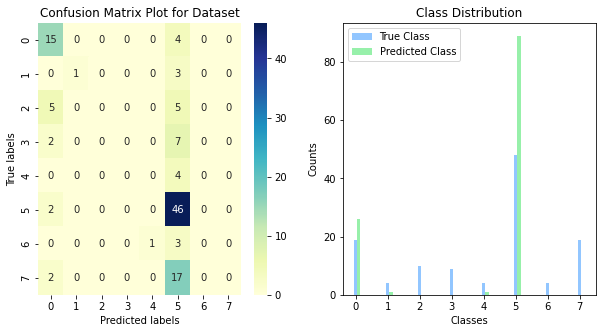

In [250]:
y_pred_neg_ts = model_neg.predict(X_CE_neg_ts_bag)
acc_CE_neg_ts = metrics.accuracy_score(y_CE_neg_test, y_pred_neg_ts)
print("The accuracy score for the Train negative tweets: {}".format(acc_CE_neg_ts))
visualize(y_CE_neg_test, y_pred_neg_ts, n=8)

#### 4.2 Reasons for bad performance
- The high class imbalance in the dataset is one of the reasons for the model's poor performance. The classes with the highest representation: Class 0 and Class 5 have over forecasts, as can be shown. 
- Additionally, because there are so few datapoints, the model is unable to generalise adequately to new data.

#### 4.3 Suggestion for performance improval

- One method to improve the performance of the model is to augment the data using synthetic data points.
- Some of the methods to create synthetic datapoints are:
  - SMOTE
  - ADASYN 
  - OverSampling
  - UnderSampling
- In addition to this, model features can be studied in more detail and some of the words which are not relevant can be eliminated.

#### 4.4 Word Frequency analysis
- This set of words can be found in a variety of ways. The favourable and bad tweets are separated in the section below. Both of them have CountVectorizer applied to them independently. For both datasets, the top 50 entries are provided in a sorted list.
- Some of the most commonly used words, such as 'election,' 'canada,' and 'Canadian,' appear in both of these tweets. These terms can be added to the stopwords list and removed before the models are run.
- There are a lot of irrelevant terms in the top 50 negative attitude words, such as would, want, wants, and so on. Lemmatization, which eliminates words with the same root word, can be used to increase performance even more.

In [252]:
CE_pos = CE_21_V1[CE_21_V1['sentiment']=='positive']
vectorizer_4 = CountVectorizer()
CE_pos_bag = vectorizer_4.fit_transform(CE_pos['text'].values)
pos_word_sum = CE_pos_bag.sum(axis=0) 
freq_word_pos = [(word, pos_word_sum[0, idx]) for word, idx in vectorizer_4.vocabulary_.items()]
freq_word_pos = sorted(freq_word_pos, key = lambda x: x[1], reverse=True)
top_50_words_pos = freq_word_pos[:50]

print('Top 50 frequent words are: \n{}'.format(top_50_words_pos))

Top 50 frequent words are: 
[('election', 397), ('vote', 188), ('canadian', 176), ('trudeau', 173), ('canadians', 141), ('otoole', 134), ('canada', 133), ('good', 74), ('elxn44', 71), ('win', 62), ('party', 60), ('federal', 59), ('get', 59), ('like', 54), ('cdnpoli', 50), ('ppc', 46), ('freedom', 45), ('day', 45), ('best', 44), ('justintrudeau', 43), ('us', 40), ('erinotoole', 40), ('ndp', 39), ('voteppc', 39), ('would', 38), ('better', 38), ('voting', 36), ('people', 36), ('hope', 36), ('support', 35), ('great', 35), ('justin', 35), ('want', 35), ('liberal', 35), ('need', 34), ('time', 33), ('right', 33), ('love', 31), ('voted', 30), ('conservatives', 30), ('dont', 30), ('think', 30), ('voteliberal', 29), ('conservative', 28), ('one', 28), ('go', 28), ('cpc', 27), ('make', 27), ('please', 27), ('parties', 26)]


In [255]:
CE_neg = CE_21_V1[CE_21_V1['sentiment']=='negative']
vectorizer_5 = CountVectorizer()
CE_neg_bag = vectorizer_5.fit_transform(CE_neg['text'].values)
neg_word_sum = CE_neg_bag.sum(axis=0) 
freq_word_neg = [(word, neg_word_sum[0, idx]) for word, idx in vectorizer_5.vocabulary_.items()]
freq_word_neg =sorted(freq_word_neg, key = lambda x: x[1], reverse=True)
top_50_words_neg = freq_word_neg[:50]

print('Top 50 frequent words are: \n{}'.format(top_50_words_neg))

Top 50 frequent words are: 
[('election', 261), ('trudeau', 150), ('canadians', 146), ('otoole', 109), ('canada', 71), ('canadian', 61), ('pandemic', 48), ('justintrudeau', 47), ('elxn44', 45), ('like', 43), ('vote', 41), ('cdnpoli', 36), ('nevervoteconservative', 30), ('called', 29), ('erinotoole', 28), ('party', 27), ('pm', 26), ('years', 24), ('dont', 24), ('one', 23), ('people', 23), ('never', 23), ('get', 23), ('justin', 23), ('conservatives', 23), ('gun', 22), ('call', 22), ('would', 21), ('calling', 21), ('us', 21), ('care', 20), ('country', 19), ('many', 19), ('erin', 19), ('good', 19), ('leader', 18), ('conservative', 18), ('going', 18), ('think', 17), ('unnecessary', 17), ('say', 17), ('know', 17), ('bad', 17), ('covid', 16), ('government', 16), ('way', 16), ('ppc', 16), ('liberals', 16), ('liberal', 16), ('see', 15)]


### 5 Conclusion
- The implementation of NLP approaches was the subject of this Jupyter notebook. 
- The data processing and cleaning procedures were investigated. Exploratory data analysis taught us several interesting principles for obtaining in-depth insights. 
- For text classification, several different models were investigated, and hyperparameter tuning was undertaken. 
- Overall, this project incorporated numerous concepts to comprehend Sentiment Analysis implementation, build discussions on the observed results, and even identify strategies to enhance the implementation.